## Simulation BASED INFERENCE for JULICH dataset

Upload basic packages

In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
import scipy as scp


import numba
from numba import jit

import matplotlib.pyplot as plt
from matplotlib import colors, cm

In [2]:
from sklearn import linear_model

Upload TVB packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#import utils
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6
from sbi_tvb import analysis, simulation
from tvb.datatypes.time_series import *
import socket
from datetime import datetime
from multiprocessing import Pool
from functools import partial
import os
from scipy.io.matlab import loadmat
from tvb.simulator.lab import *
#import ipywidgets as widgets
# Pay attention that it crashes with any other interactive package
#from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive
LOG = get_logger('demo')
import scipy.stats
#import sklearn
#from sklearn.decomposition import FastICA
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re

2021-06-14 13:06:34,991 - WARNING - tvb.simulator.common - psutil module not available: no warnings will be issued when a
    simulation may require more memory than available
   INFO  log level set to INFO


/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/tvb/datatypes/surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


Import the SBI packages

In [4]:
import torch
import sbi 
import sbi.utils as utils
from sbi.inference.base import infer

from sbi.inference import SNPE, SNLE, SNRE, prepare_for_sbi,simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn

from scipy import signal
from scipy.signal import hilbert

from scipy import stats as spstats
from scipy.stats import moment
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import mode

import scipy

from scipy.optimize import fsolve
from scipy.optimize import root

from numpy import linalg as LA
from sklearn.decomposition import PCA

Define your target/results folder

In [5]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on numba: v{}'.format(numba.__version__))
print('Running on torch: v{}'.format(torch.__version__))
print('Running on sbi: v{}'.format(sbi.__version__))
print('Running on numba: v{}'.format(numba.__version__))

Running on numpy: v1.20.3
Running on numba: v0.53.1
Running on torch: v1.8.1+cu102
Running on sbi: v0.16.0
Running on numba: v0.53.1


Upload the data. You can use the class data of the Virtual Ageing Brain or uncomment the local folder upload. For the latter, **MODIFY THE run_sim() accordingly**

In [6]:
bold                 = np.loadtxt(os.path.join('data_input_files','meanTS_GS_bptf_Schaefer100_7NW.txt'))
weights              = np.loadtxt(os.path.join('data_input_files','SC_Schaefer7NW100p_nolog10.txt'))
BOLD_TR      = 2250


In [45]:
Res_dir     = 'results'
if not os.path.exists(Res_dir):
    os.makedirs(Res_dir)
#path_root   = os.path.dirname(os.path.dirname(os.getcwd()))
#cwd = os.getcwd()

# Montbrio MODEL 

Define the simulation function via TVB backend and time rescaling. The BOLD is derived moving average of the R signal

In [8]:
def run_sim(G,nsigma,weights,sim_len,BOLD_TR):
    
    t0 = time.time()
    
#     jul                                       = data.Julich()
#     subjs                                     = jul.list_subjects()
#     subj_age,gender,education,subj_ID,_,_,_,_ = jul.metadata()
    magic_number = 124538.470647693

#     SUBJ_TARG     = [subj_loc for subj_loc in range(len(subj_ID)) if mysubj in subj_ID[subj_loc] ][0]
#     myage         = subj_age[SUBJ_TARG]

#     _, weights    = jul.load_subject_sc_100(mysubj)
    NHALF         = int(weights.shape[0]/2)

#     print(mysubj,flush=True)
#     print(subj_ID[SUBJ_TARG],flush=True)
#     print(myage,flush=True)
#     print(str(tau),flush=True)
#     print(str(G),flush=True)

    weights_orig                            = weights/magic_number
    weights_symm                            = weights_orig 

    
    conn               = connectivity.Connectivity(
        weights=weights_symm,
        region_labels=np.array(np.zeros(np.shape(weights_symm)[0]),dtype='<U128'),
        tract_lengths=np.zeros(np.shape(weights_symm)),
        areas =np.zeros(np.shape(weights_symm)[0]),
        speed=np.array(np.Inf,dtype=float),
        centres = np.zeros(np.shape(weights_symm)[0])) # default 76 regions 
    # conn_speed         = np.Inf  
    # conn.weights       = weights_symm
    # conn.areas         = np.zeros(np.shape(weights_symm))
    # conn.tract_lengths = np.zeros(np.shape(weights_symm))
#     print('weight:',weights_symm) 
#     print('shape :',np.shape(conn.weights))
#     print('conn :', conn.weights)

    mpr=models.MontbrioPazoRoxin(
            eta   = np.r_[-4.6],
            J     = np.r_[14.5],
            Delta = np.r_[0.7],
            tau   = np.r_[1],
        )
#     mpr.state_variable_range['r'] = np.array([0.,.25])

    sim = simulator.Simulator(model=mpr,
    connectivity=conn,
        coupling=coupling.Scaling(
          a=np.r_[G]
        ),
    conduction_speed=np.Inf,
        integrator=integrators.HeunStochastic(
          dt=dt,
          noise=noise.Additive(
              nsig=np.r_[nsigma, nsigma*2],
              noise_seed=seed
          )
    ),
    monitors=[
          monitors.TemporalAverage(period=0.1),
        ]
    )

    sim.configure()

    (TemporalAverage_time, TemporalAverage_data), = simulation.run_nbMPR_backend(sim, simulation_length=sim_len)
    TemporalAverage_time *= 10 # rescale time
    
#     Bold_time, Bold_data = simulation.tavg_to_bold(TemporalAverage_time, TemporalAverage_data, tavg_period=1., connectivity=sim.connectivity, svar=0, decimate=2000)
    
    R_TAVG = TemporalAverage_data[:,0,:,0]
#     V = TemporalAverage_data[:,1,:,0]
    
    R = scipy.signal.decimate(R_TAVG, BOLD_TR, n=None, ftype='fir',axis=0)

#     CPU_TIME = time.time() - t0
#     print(['CPU time-->',CPU_TIME])


    return R.T
    
    


### simulation set up

In [9]:
dt         = 0.005
eta        = -4.6
J          = 14.5
Delta      = 0.7
tau        = 1.7
nsigma     = 0.035
seed       = 42
sim_len    = 30e3

In [10]:
G          = 2.45

### sanity check

Check if the simulation with backend works and the CPU time for each run. According to Meysam's formalism, each signal matrix MUST BE (NODES X TIME). 

In [11]:
start_time = time.time()
BOLD_r     = run_sim(G,nsigma,weights,sim_len,BOLD_TR)
# bold_data = run_sim(G,nsigma,mysubj,alpha,sim_len)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 207.20010042190552


In [12]:
BOLD_r.shape

(100, 134)

In [13]:
nt = BOLD_r.shape[1]
nn = BOLD_r.shape[0]

nn, nt

(100, 134)

### data features

Compute the summary statistics via numpy and scipy. The function here extracts 10 momenta for each bold channel, FC mean, FCD mean, variance difference and standard deviation of FC stream. Check that you can compute FCD features via proper FCD packages

In [14]:
from scipy import signal
from scipy.signal import hilbert

from scipy import stats as spstats
from scipy.stats import moment
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import mode



from scipy.optimize import fsolve
from scipy.optimize import root

from numpy import linalg as LA
from sklearn.decomposition import PCA

In [15]:
def calculate_summary_statistics(x, nn,bold_dt,features):
    """Calculate summary statistics

    Parameters
    ----------
    x : output of the simulator

    Returns
    -------
    np.array, summary statistics
    """
    
#     X = np.reshape(x,(nn, int(x.shape[0]/nn)))
    X = x.reshape(nn, int(x.shape[0]/nn))

    n_summary = 16*nn+(nn*nn)+300*300

    wwidth=30
    maxNwindows=200
    olap=0.96
        
    sum_stats_vec = np.concatenate((np.mean(X, axis=1), 
                                    np.median(X, axis=1),
                                    np.std(X, axis=1),
                                    skew(X, axis=1), 
                                    kurtosis(X, axis=1),
                                    ))

#     sum_stats_vec = []

    for item in features:

            if item == 'higher_moments':

                        sum_stats_vec = np.concatenate((sum_stats_vec,
                                                moment(X, moment=2, axis=1),
                                                moment(X, moment=3, axis=1),
                                                moment(X, moment=4, axis=1),
                                                moment(X, moment=5, axis=1), 
                                                moment(X, moment=6, axis=1), 
                                                moment(X, moment=7, axis=1), 
                                                moment(X, moment=8, axis=1), 
                                                moment(X, moment=9, axis=1), 
                                                moment(X, moment=10, axis=1), 
                                                                   ))

            if item == 'FC_corr':

                        FC=np.corrcoef(X)
                        off_diag_sum_FC = np.sum(FC) - np.trace(FC)
                        #eigen_vals_FC, _ = LA.eig(FC)
                        #pca = PCA(n_components=3)
                        #PCA_FC = pca.fit_transform(FC)
                        print('FC_Corr')
                        sum_stats_vec = np.concatenate((sum_stats_vec,
                                        np.array([off_diag_sum_FC]),
                                                       ))

            if item == 'FCD_corr':

#                         FCDcorr,Pcorr,shift=extract_FCD(X,wwidth,maxNwindows,olap,mode='corr')

                        win_FCD                       = 40e3
                        NHALF                         = int(nn/2)
                    
                        mask_inter                              = np.zeros([nn,nn])
                        mask_inter[0:NHALF,NHALF:NHALF*2]       = 1
                        mask_inter[NHALF:NHALF*2,0:NHALF]       = 1
                        
                        bold_summ_stat = X.T
                    
                        FCD, fc_stack, speed_fcd      = analysis.compute_fcd(bold_summ_stat, win_len=int(win_FCD/bold_dt), win_sp=1)
                        fcd_inter, fc_stack_inter, _  = analysis.compute_fcd_filt(bold_summ_stat,mask_inter,win_len=int(win_FCD/bold_dt),win_sp=1)
                        
                        FCD_TRIU            = np.triu(FCD, k=1)

                        FCD_INTER_TRIU      = np.triu(fcd_inter, k=1)


                        FCD_MEAN       = np.mean(FCD_TRIU)
                        FCD_VAR        = np.var(FCD_TRIU)
                        FCD_OSC        = np.std(fc_stack)
                        FCD_OSC_INTER  = np.std(fc_stack_inter)

                        FCD_MEAN_INTER       = np.mean(FCD_INTER_TRIU)
                        FCD_VAR_INTER        = np.var(FCD_INTER_TRIU)
                        
                        DIFF_VAR             = FCD_VAR_INTER - FCD_VAR

                        sum_stats_vec = np.concatenate((sum_stats_vec,
                                        np.array([FCD_MEAN]), np.array([FCD_OSC_INTER]), np.array([DIFF_VAR])
                                                       ))
            
    sum_stats_vec = sum_stats_vec[0:n_summary]        


    return sum_stats_vec


In [16]:
# _=calculate_summary_statistics(BOLD_r, nn, BOLD_TR, features=['higher_moments','FC_corr', 'FCD_corr'])
bold_summary_statistics=calculate_summary_statistics(BOLD_r.reshape(-1), nn, BOLD_TR, features=['higher_moments','FC_corr', 'FCD_corr'])
bold_summary_statistics.shape

FC_Corr


(1404,)

### 1. Simulator wrapper

Define the wrapper such that you can iterate the simulator with SBI

In [17]:
def MPR_simulator_wrapper(params):

    params = np.asarray(params)
    
    #params_alpha=params[0]
    params_G=params[0]

    BOLD_r_sim = run_sim(params_G,nsigma,weights,sim_len,BOLD_TR);
     
    summstats = torch.as_tensor(calculate_summary_statistics(BOLD_r_sim.reshape(-1), nn, BOLD_TR, features=['higher_moments','FC_corr', 'FCD_corr']))

    return summstats 

### 2. Prior over model parameters

Define the uniform prior and store it in a utils function for the SBI inference

In [18]:
prior_min_alpha=0.
prior_min_G=1.5*np.ones(1)

prior_max_alpha=1.
prior_max_G=3.2*np.ones(1)

In [19]:
# prior_min=np.hstack([prior_min_alpha, prior_min_G])
# prior_max=np.hstack([prior_max_alpha, prior_max_G])

prior_min=np.hstack([prior_min_G])
prior_max=np.hstack([prior_max_G])

In [20]:
prior_min.shape, prior_max.shape

((1,), (1,))

In [21]:
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))
prior

BoxUniform(Uniform(low: tensor([1.5000]), high: tensor([3.2000])), 1)

### 3. Inference

Inference procedure. Although the inference function is defined in the SBI toolbox, the function below shows that you can potentially split the simulation step from the inference 
in case that it is needed. For example, the simulation time for the wrappper is too long and you might want to parallelize on HPC facilities. The inference function produces a posterorior object, which contains a neural network for posterior density estimation

In [22]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union, cast
# from warnings import warn

# import torch
# from torch import Tensor
# from torch.utils import data
# from torch.utils.tensorboard import SummaryWriter

import sbi.inference
from sbi.inference.posteriors.base_posterior import NeuralPosterior

In [41]:
def myinfer(
    simulator: Callable, prior, method: str, num_simulations: int, num_workers: int = 1
) -> NeuralPosterior:

    try:
        method_fun: Callable = getattr(sbi.inference, method.upper())
    except AttributeError:
        raise NameError(
            "Method not available. `method` must be one of 'SNPE', 'SNLE', 'SNRE'."
        )

    simulator, prior = prepare_for_sbi(simulator, prior)

    inference = method_fun(prior)
    theta, x = simulate_for_sbi(
        simulator=simulator,
        proposal=prior,
        num_simulations=num_simulations,
        num_workers=num_workers,
        show_progress_bar=True,
    )
    
    
    print(theta,flush=True)
    print(theta.shape,flush=True)
    print(x,flush=True)
    print(x.shape,flush=True)
    
    _ = inference.append_simulations(theta, x).train()
    posterior = inference.build_posterior()    
    
    mysavepath = os.path.join(Res_dir, 'inference_theta_jn_sim.npz')
    np.savez(mysavepath,theta=theta,x=x)

    return posterior

In [42]:
mysavepath = os.path.join(Res_dir, 'inference_theta_jn_sim.npz')

In [46]:
start_time = time.time()

posterior = myinfer(MPR_simulator_wrapper, prior, method='SNPE',  num_simulations=20, num_workers=1)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

FC_Corr
FC_Corr


Running 20 simulations.:   0%|          | 0/20 [00:00<?, ?it/s]

FC_Corr
FC_Corr


/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/numpy/core/_methods.py:211: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/scipy/stats/stats.py:1086: RuntimeWarning: overflow encountered in square
  s = a_zero_mean**2
/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/scipy/stats/stats.py:1090: RuntimeWarning: overflow en

FC_Corr


/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/numpy/core/_methods.py:211: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/scipy/stats/stats.py:1086: RuntimeWarning: overflow encountered in square
  s = a_zero_mean**2
/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/scipy/stats/stats.py:1090: RuntimeWarning: overflow en

FC_Corr


/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/numpy/core/_methods.py:211: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/scipy/stats/stats.py:1086: RuntimeWarning: overflow encountered in square
  s = a_zero_mean**2
/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/scipy/stats/stats.py:1090: RuntimeWarning: overflow en

FC_Corr
FC_Corr
FC_Corr
FC_Corr
FC_Corr
FC_Corr


/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/numpy/core/_methods.py:211: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/scipy/stats/stats.py:1086: RuntimeWarning: overflow encountered in square
  s = a_zero_mean**2
/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/scipy/stats/stats.py:1090: RuntimeWarning: overflow en

FC_Corr
FC_Corr
FC_Corr
FC_Corr
FC_Corr


/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


FC_Corr
FC_Corr
FC_Corr


/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/numpy/core/_methods.py:211: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/numpy/core/_methods.py:243: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/scipy

FC_Corr
FC_Corr
tensor([[1.7881],
        [2.5827],
        [3.0356],
        [2.6882],
        [3.0182],
        [1.9968],
        [2.0342],
        [2.4781],
        [1.5761],
        [2.2755],
        [3.1161],
        [2.2234],
        [1.5618],
        [1.5514],
        [3.0635],
        [2.1692],
        [2.4599],
        [1.7666],
        [2.8733],
        [2.6938]])
torch.Size([20, 1])
tensor([[0.1127, 0.1126, 0.1148,  ..., 0.0634, 0.1299, 0.0014],
        [0.2189, 0.1879, 0.1585,  ..., 0.1395, 0.1422, 0.0042],
        [   inf,    inf,    inf,  ...,    nan,    nan,    nan],
        ...,
        [0.1126, 0.1126, 0.1148,  ..., 0.0634, 0.1306, 0.0016],
        [   inf,    inf,    inf,  ...,    nan,    nan,    nan],
        [   inf,    inf,    inf,  ...,    nan,    nan,    nan]])
torch.Size([20, 1404])
WARNING  Found 7 NaN simulations and 6 Inf simulations. They will be excluded from training.


/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/numpy/core/_methods.py:211: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/scipy/stats/stats.py:1086: RuntimeWarning: overflow encountered in square
  s = a_zero_mean**2
/home/izaak/local_repos/nostromo/tvb-inversion/mpr_sbi_tvb/env/lib/python3.8/site-packages/scipy/stats/stats.py:1090: RuntimeWarning: overflow en

Neural network successfully converged after 130 epochs.
------------------------------------------------------------
--- 4748.607769727707 seconds ---


### SUMMARY STATISTICS TO GET THE POSTERIOR

In order to compute $p(\theta|x)$, you need to pass a vector of summary statistics input $x$ to the ANN-posterior estimator. It can either be defined on target simulation data for validation purposes or the empirical data for "therapy" reason

In [47]:
alpha_true= 0.0
beta_true = 0.0
G_true    = 2.45

In [48]:
labels_params = [r'$G$']

In [49]:
params_true = np.hstack([alpha_true, G_true])

The block below chooses between a validation with a simulation or empirical data

In [50]:
## IF you want to benchmark simualtions
BOLD_obs = run_sim(G_true,nsigma,weights,sim_len,BOLD_TR);
## IF you want empirical data
# bold_emp = jul.load_subject_fc_100(mysubj)
# BOLD_obs = bold_emp.T

In [51]:
obs_summary_statistics=calculate_summary_statistics(BOLD_obs.reshape(-1), nn, 2250, features=['higher_moments','FC_corr', 'FCD_corr'])

FC_Corr


In [52]:
BOLD_obs.shape, obs_summary_statistics.shape

((100, 134), (1404,))

## POSTERIOR DISTRIBUTION

The last step derive or upload the posterior

In [53]:
alpha_true= 0.0
beta_true = 0.0
G_true    = 2.45

In [54]:
params_true = np.hstack([G_true])

In [55]:
num_samples=1000

In [56]:
posterior_samples = posterior.sample((num_samples,), obs_summary_statistics, sample_with_mcmc=True,).numpy()

Generating samples: 100%|██████████| 1000/1000 [07:16<00:00,  2.29it/s]


In [57]:
mysavepath = os.path.join(Res_dir, 'posterior_samples_jn_sim.npz')
np.savez(mysavepath,posterior_samples=posterior_samples)

In [60]:
#mysavepath  = os.path.join(Res_dir, 'inference_theta_emp_100sim.npz')
mysavepath  = os.path.join(Res_dir, 'inference_theta_jn_sim.npz')
myinference = np.load(mysavepath)
theta = myinference['theta']
x     = myinference['x']
x

array([[0.1126783 , 0.11256757, 0.11484358, ..., 0.06342938, 0.12990344,
        0.00136276],
       [0.21887308, 0.18787538, 0.15850255, ..., 0.1394502 , 0.1422401 ,
        0.00417313],
       [       inf,        inf,        inf, ...,        nan,        nan,
               nan],
       ...,
       [0.112604  , 0.11257225, 0.1148175 , ..., 0.06337447, 0.13055809,
        0.00161271],
       [       inf,        inf,        inf, ...,        nan,        nan,
               nan],
       [       inf,        inf,        inf, ...,        nan,        nan,
               nan]], dtype=float32)

In [61]:
 mysavepath = os.path.join(Res_dir, 'posterior_samples_jn_sim.npz')
# mysavepath  = os.path.join(Res_dir,'posterior_samples_MPR_aged_obs1.npz')
# mysavepath  = os.path.join(Res_dir,'posterior_samples_MPR_EMP_100sim.npz')
# np.savez(mysavepath,posterior_samples=posterior_samples)

In [62]:
myposterior = np.load(mysavepath)

In [63]:
posterior_samples = myposterior['posterior_samples']

In [64]:
G_posterior=posterior_samples[:,0]

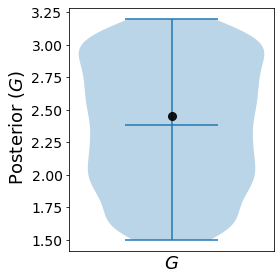

In [65]:
plt.figure(figsize=(4,4))
parts= plt.violinplot(G_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.plot(1,params_true[0] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior ' +r'${(G)}$', fontsize=18);  
plt.xlabel(r'${G}$', fontsize=18); 
plt.xticks([])
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()